In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!pip install tensorflow scikit-learn pandas matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, Input

Mounted at /content/gdrive


In [ ]:
#Data generation - cell needs to be run just once
from simLIBS import SimulatedLIBS
import numpy as np
import pandas as pd
import os

output_dir = '/content/gdrive/My Drive/nist_libs_data/'  # or your local path
os.makedirs(output_dir, exist_ok=True)

elements = ['Al', 'Fe', 'Cu', 'Ca', 'Au']
n_samples = 1000  # or more
Te_range = (0.5, 1.5)  # eV
Ne_range = (1e16, 1e20)  # cm^-3
resolution = 1000
wavelength_range = (200, 800)

labels = []
for i in range(n_samples):
    print(f"Generating sample {i+1}/{n_samples} ...")
    au = np.random.uniform(1, 5)
    rest = 100 - au

    dirichlet_sample = np.random.dirichlet(np.ones(4))
    other_percents = (dirichlet_sample * rest).tolist()
    other_percents[3] = rest - sum(other_percents[:3])
    percentages = other_percents + [au]

    percentages = np.array(percentages)
    percentages[-1] = 100.0 - np.sum(percentages[:-1])
    if np.any(percentages < 0):
        percentages[percentages < 0] = 0
        percentages[-1] = 100.0 - np.sum(percentages[:-1])
    assert np.isclose(np.sum(percentages), 100.0, atol=1e-8)
    percentages = percentages.tolist()

    Te = np.random.uniform(*Te_range)
    Ne = np.random.uniform(*Ne_range)
    print("Percentages:", percentages, "Sum:", sum(percentages))
    libs = SimulatedLIBS(
        Te=Te,
        Ne=Ne,
        elements=elements,
        percentages=percentages,
        resolution=resolution,
        low_w=wavelength_range[0],
        upper_w=wavelength_range[1],
        max_ion_charge=2,
        webscraping='static'
    )
    filename = f'sample_{i:03d}.csv'
    filepath = os.path.join(output_dir, filename)
    libs.save_to_csv(filepath)
    labels.append({
        'filename': filename,
        'Al': percentages[0],
        'Fe': percentages[1],
        'Cu': percentages[2],
        'Ca': percentages[3],
        'Au': percentages[4],
        'Te': Te,
        'Ne': Ne
    })

labels_df = pd.DataFrame(labels)
labels_df.to_csv(os.path.join(output_dir, 'labels.csv'), index=False)

Generating sample 1/1000 ...
Percentages: [36.59378861511744, 20.693843860154146, 26.038601313432462, 15.2086672698682, 1.4650989414277547] Sum: 100.0
Generating sample 2/1000 ...
Percentages: [20.423912856522843, 51.40090333022063, 9.964174587155668, 16.692034633023937, 1.5189745930769192] Sum: 100.0
Generating sample 3/1000 ...
Percentages: [3.5590481982325652, 24.059195197269315, 26.150461613799376, 43.11347203297271, 3.117822957726034] Sum: 100.0
Generating sample 4/1000 ...
Percentages: [13.84562904302463, 14.569871565309468, 62.1139735851253, 6.927473835644179, 2.543051970896414] Sum: 100.0
Generating sample 5/1000 ...
Percentages: [30.324182419279953, 18.376532249292456, 45.17928887264388, 4.342943808208645, 1.7770526505750581] Sum: 100.0
Generating sample 6/1000 ...
Percentages: [20.240834591800418, 48.338629860956615, 2.494810338296289, 27.54586012019439, 1.3798650887522825] Sum: 100.0
Generating sample 7/1000 ...
Percentages: [3.5402606498913176, 14.050848081329718, 72.846442

In [ ]:
data_dir = '/content/gdrive/My Drive/nist_libs_data/'

# List all .csv files except labels.csv
file_list = sorted(glob.glob(os.path.join(data_dir, '*.csv')))
spectra_files = [f for f in file_list if not f.endswith('labels.csv')]

spectra = []
for file in spectra_files:
    df = pd.read_csv(file)
    if 'intensity' in df.columns:
        spectra.append(df['intensity'].values)
    else:
        raise ValueError(f"File {file} does not contain 'intensity' column")
X = np.stack(spectra)  # shape: (n_samples, n_wavelengths)

In [ ]:
labels_df = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
y_concentration = labels_df[['Al', 'Fe', 'Cu', 'Ca', 'Au']].values
y_te = labels_df[['Te']].values
y_ne_log = np.log10(labels_df[['Ne']].values)  # Use log10(Ne) for stability

# Scale targets
scaler_conc = StandardScaler()
scaler_te = StandardScaler()
scaler_ne = StandardScaler()
y_concentration_scaled = scaler_conc.fit_transform(y_concentration)
y_te_scaled = scaler_te.fit_transform(y_te)
y_ne_scaled = scaler_ne.fit_transform(y_ne_log)

In [ ]:
# Normalize each spectrum (row-wise min-max)
X_norm = (X - X.min(axis=1, keepdims=True)) / (X.max(axis=1, keepdims=True) - X.min(axis=1, keepdims=True) + 1e-8)

# Train-test split
X_train, X_test, y_train_conc, y_test_conc, y_train_te, y_test_te, y_train_ne, y_test_ne = train_test_split(
    X_norm, y_concentration_scaled, y_te_scaled, y_ne_scaled, test_size=0.2, random_state=42
)
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

In [ ]:
input_layer = Input(shape=(X_train_cnn.shape[1], 1))
x = layers.Conv1D(64, 7, activation='relu', padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)

conc_out = layers.Dense(5, name='concentration')(x)
te_out = layers.Dense(1, name='te')(x)
ne_out = layers.Dense(1, name='ne')(x)

model = models.Model(inputs=input_layer, outputs=[conc_out, te_out, ne_out])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
    loss={'concentration': 'mse', 'te': 'mse', 'ne': 'mse'},
    loss_weights=[1.0, 1.0, 1.0],
    metrics={'concentration': ['mae'], 'te': ['mae'], 'ne': ['mae']}
)
model.summary()

history = model.fit(
    X_train_cnn,
    {'concentration': y_train_conc, 'te': y_train_te, 'ne': y_train_ne},
    epochs=150,
    batch_size=16,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=8)
    ],
    verbose=1
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 6000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 6000, 64)  │        512 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6000, 64)  │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 6000, 64)  │     20,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6000, 64)  │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concentration       │ (None, 5)         │        325 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ te (Dense)          │ (None, 1)         │         65 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ne (Dense)          │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,599 (150.78 KB)

 Trainable params: 38,343 (149.78 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 633ms/step - concentration_loss: 1.0135 - concentration_mae: 0.8294 - loss: 2.6902 - ne_loss: 0.9347 - ne_mae: 0.6685 - te_loss: 0.7420 - te_mae: 0.7067 - val_concentration_loss: 0.9502 - val_concentration_mae: 0.8072 - val_loss: 2.6269 - val_ne_loss: 0.7252 - val_ne_mae: 0.6807 - val_te_loss: 0.9515 - val_te_mae: 0.8625 - learning_rate: 0.0010
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 603ms/step - concentration_loss: 0.9565 - concentration_mae: 0.8109 - loss: 2.6243 - ne_loss: 1.0331 - ne_mae: 0.7661 - te_loss: 0.6347 - te_mae: 0.6614 - val_concentration_loss: 0.9654 - val_concentration_mae: 0.8107 - val_loss: 2.6629 - val_ne_loss: 0.7506 - val_ne_mae: 0.6644 - val_te_loss: 0.9469 - val_te_mae: 0.8587 - learning_rate: 0.0010
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 631ms/step - concentration_loss: 0.9352 - concentration_mae: 0.7976 - loss: 2.7571 - ne_loss: 1.1948 - ne_mae: 0.7728 - te_loss: 0.6271 - te_mae: 0.6620 - val_concentration_loss

In [ ]:
pred_conc, pred_te, pred_ne = model.predict(X_test_cnn)

# Inverse-transform predictions and targets
pred_conc_unscaled = scaler_conc.inverse_transform(pred_conc)
pred_te_unscaled = scaler_te.inverse_transform(pred_te)
pred_ne_log = scaler_ne.inverse_transform(pred_ne)
y_test_conc_unscaled = scaler_conc.inverse_transform(y_test_conc)
y_test_te_unscaled = scaler_te.inverse_transform(y_test_te)
y_test_ne_log = scaler_ne.inverse_transform(y_test_ne)

def safe_exp10(arr, min_exp=10, max_exp=20):
    arr = np.clip(arr, min_exp, max_exp)
    return 10 ** arr

pred_ne_unscaled = safe_exp10(pred_ne_log)
y_test_ne_unscaled = safe_exp10(y_test_ne_log)

# Concentrations (all elements)
rmse_conc = np.sqrt(mean_squared_error(y_test_conc_unscaled, pred_conc_unscaled))
r2_conc = r2_score(y_test_conc_unscaled, pred_conc_unscaled)
mae_conc = np.mean(np.abs(y_test_conc_unscaled - pred_conc_unscaled))

# Te
rmse_te = np.sqrt(mean_squared_error(y_test_te_unscaled, pred_te_unscaled))
r2_te = r2_score(y_test_te_unscaled, pred_te_unscaled)
mae_te = np.mean(np.abs(y_test_te_unscaled - pred_te_unscaled))

# Ne
rmse_ne_log = np.sqrt(mean_squared_error(y_test_ne_log, pred_ne_log))
r2_ne_log = r2_score(y_test_ne_log, pred_ne_log)
mae_ne_log = np.mean(np.abs(y_test_ne_log - pred_ne_log))

print(f"Test RMSE (Concentrations): {rmse_conc:.4f}")
print(f"Test R² (Concentrations): {r2_conc:.4f}")
print(f"Test MAE (Concentrations): {mae_conc:.4f}")
print(f"Test RMSE (Te): {rmse_te:.4f}")
print(f"Test R² (Te): {r2_te:.4f}")
print(f"Test MAE (Te): {mae_te:.4f}")
print(f"Test RMSE (Ne): {rmse_ne_log:.4f}")
print(f"Test R² (Ne): {r2_ne_log:.4f}")
print(f"Test MAE (Ne): {mae_ne_log:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
Test RMSE (Concentrations): 12.7418
Test R² (Concentrations): 0.3863
Test MAE (Concentrations): 9.2468
Test RMSE (Te): 0.1456
Test R² (Te): 0.7697
Test MAE (Te): 0.1119
Test RMSE (Ne): 0.3690
Test R² (Ne): 0.0238
Test MAE (Ne): 0.2893


In [ ]:
for i, name in enumerate(['Al', 'Fe', 'Cu', 'Ca', 'Au']):
    r2 = r2_score(y_test_conc_unscaled[:, i], pred_conc_unscaled[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_conc_unscaled[:, i], pred_conc_unscaled[:, i]))
    mae = np.mean(np.abs(y_test_conc_unscaled[:, i] - pred_conc_unscaled[:, i]))
    print(f"{name}: R²={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")


Al: R²=0.570, RMSE=13.02, MAE=10.17
Fe: R²=0.712, RMSE=10.58, MAE=8.46
Cu: R²=0.364, RMSE=16.06, MAE=12.98
Ca: R²=0.307, RMSE=16.47, MAE=13.62
Au: R²=-0.022, RMSE=1.14, MAE=0.99


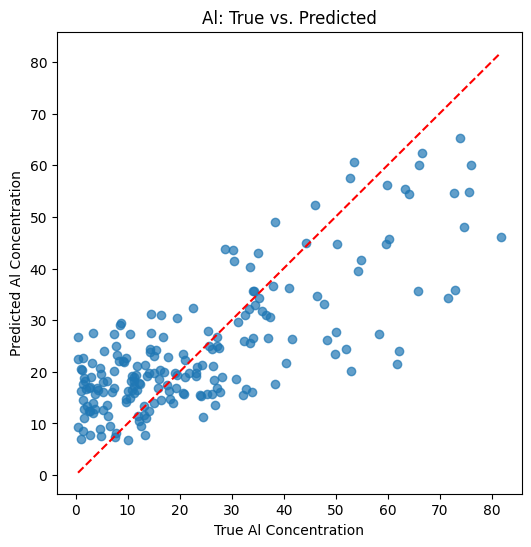

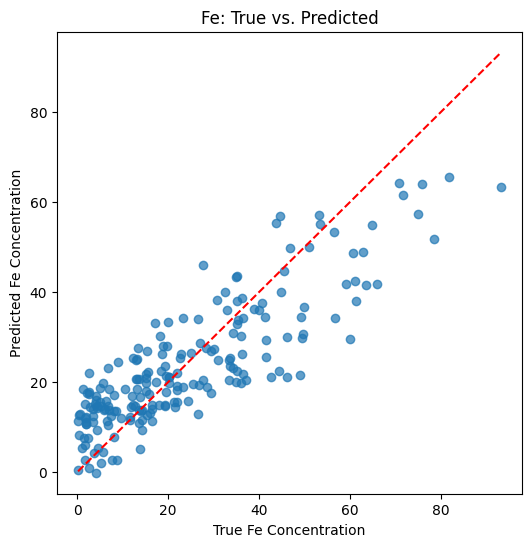

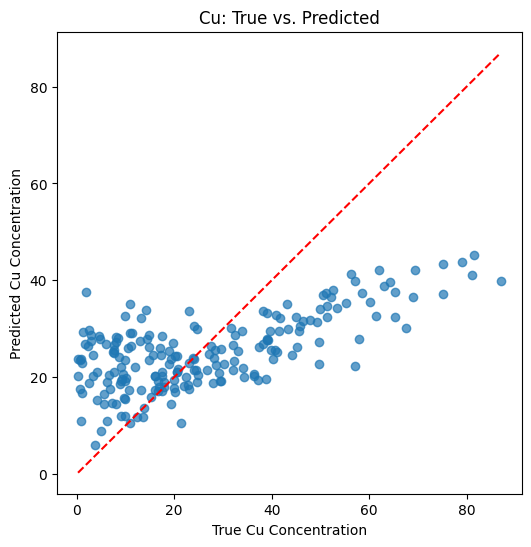

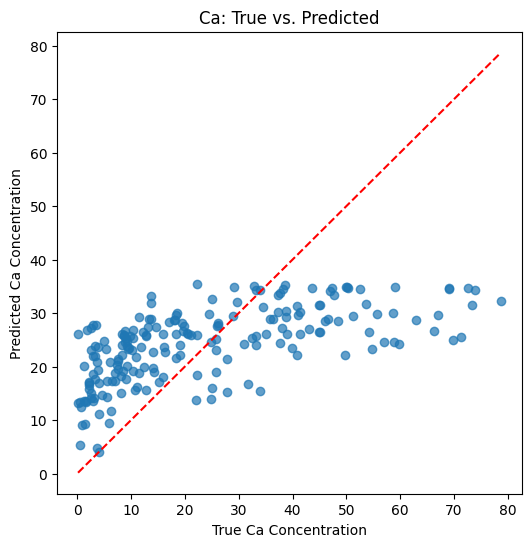

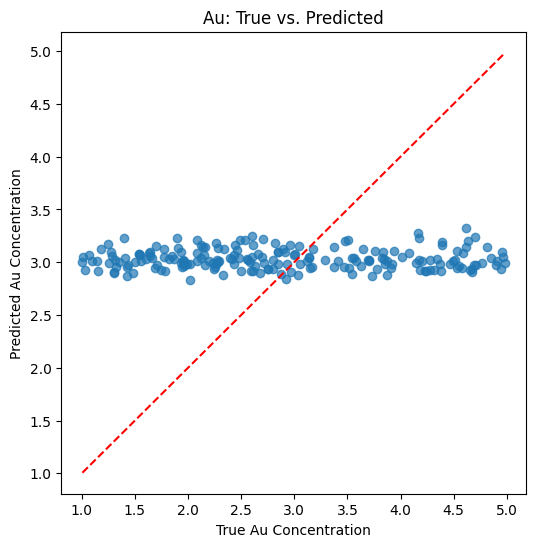

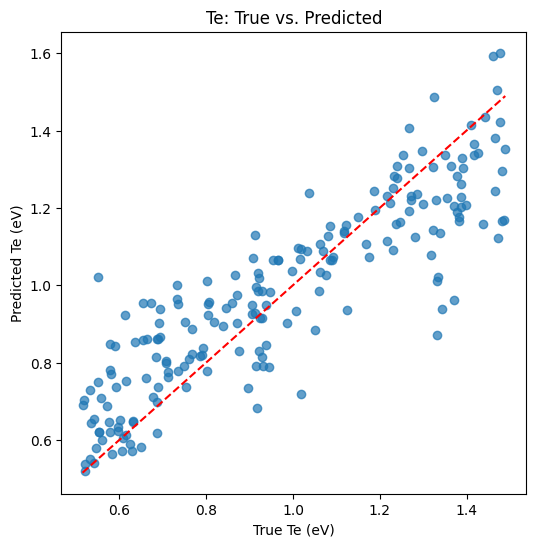

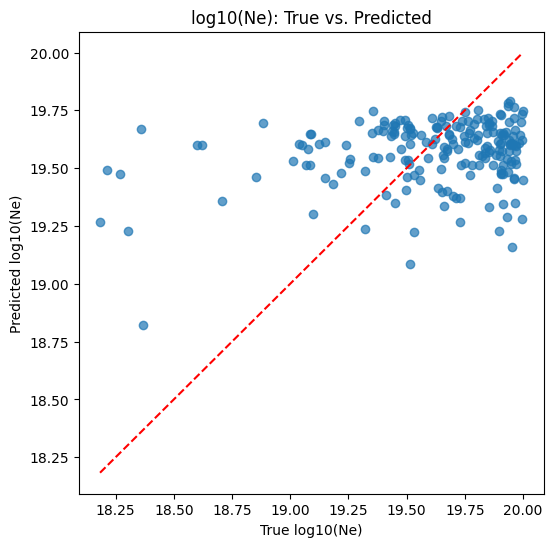

In [ ]:
element_names = ['Al', 'Fe', 'Cu', 'Ca', 'Au']
for i, name in enumerate(element_names):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_conc_unscaled[:, i], pred_conc_unscaled[:, i], alpha=0.7)
    plt.plot([y_test_conc_unscaled[:, i].min(), y_test_conc_unscaled[:, i].max()],
             [y_test_conc_unscaled[:, i].min(), y_test_conc_unscaled[:, i].max()], 'r--')
    plt.xlabel(f'True {name} Concentration')
    plt.ylabel(f'Predicted {name} Concentration')
    plt.title(f'{name}: True vs. Predicted')
    plt.show()

# Te
plt.figure(figsize=(6,6))
plt.scatter(y_test_te_unscaled, pred_te_unscaled, alpha=0.7)
plt.plot([y_test_te_unscaled.min(), y_test_te_unscaled.max()],
         [y_test_te_unscaled.min(), y_test_te_unscaled.max()], 'r--')
plt.xlabel('True Te (eV)')
plt.ylabel('Predicted Te (eV)')
plt.title('Te: True vs. Predicted')
plt.show()

# Ne (log scale)
plt.figure(figsize=(6,6))
plt.scatter(y_test_ne_log, pred_ne_log, alpha=0.7)
plt.plot([y_test_ne_log.min(), y_test_ne_log.max()],
         [y_test_ne_log.min(), y_test_ne_log.max()], 'r--')
plt.xlabel('True log10(Ne)')
plt.ylabel('Predicted log10(Ne)')
plt.title('log10(Ne): True vs. Predicted')
#plt.xscale('log')
#plt.yscale('log')
plt.show()